# Import Section

In [1]:
from audapter.driver.filter_driver import FilterDriver

In [2]:
import numpy as np
from scipy.fft import rfft, irfft, rfftfreq, fft, ifft, fftfreq
from nptyping import Array

In [3]:
from matplotlib import pylab as plt
import seaborn as sns

sns.set()
sns.set_context('paper')
sns.set_palette('Set2', 2)

## import Virtual Error Source

In [4]:
from pysndfx import AudioEffectsChain

SOUND_FIELD = lambda x: 2. * x.copy()
# AEC = AudioEffectsChain()
# SOUND_FIELD = AEC.overdrive()

## import Warning Controller

In [5]:
from warnings import simplefilter
simplefilter('ignore')

# Define Global Variables

In [6]:
# Period
T_msec = 100

# Sample rate
fs = 44100
nyquist = fs//2

# Data size
N = fs * T_msec // 1000

# Filter Length
w_len = 10

# Maximum Amplifier
A_max = 256

# Amplifier
A = .8 * A_max

# Frequency of sound
w_sound = 440.

# Time
END_OF_TIME = 20
t = np.linspace(0, END_OF_TIME, fs*END_OF_TIME, dtype=np.float64)

## Make Arrays for Caching

In [7]:
x_cache = A * np.sin(w_sound * (2 * np.pi * t))

d_cache = x_cache[:]

y_cache = np.zeros_like(t)

f_cache = np.zeros_like(y_cache)

w_cache = np.zeros((END_OF_TIME*1000//T_msec, w_len), dtype=np.float64)

# Main Section

## in First Step

In [8]:
## START_OF_THREAD ##
x_now = x_cache[: N]
# Output(FOR sound-field, FOR NOW, pass thru)
y_now = x_now.copy()
f_now = SOUND_FIELD(y_now[:])
# Caching
y_cache[: N] = y_now[:]
f_cache[: N] = f_now[:]

In [9]:
# Filter
driver = FilterDriver(shape=w_len)

w_cache[0] = driver.get_filter_weights()[:]

for i in range(1, END_OF_TIME * 1000//T_msec):
    
    ## START_OF_THREAD ##
    
    # Desired signal IN PREV
    d = d_cache[(i-1)*N  : i*N - w_len]
    
    # Make input-array from 'f'
    f_indata = np.array([f_cache[(i-1)*N+n : (i-1)*N+n + w_len] for n in range(N - w_len)])
    
    # Filter weight matrix(in time)
    w_new = driver.tune(desired=d, data_in=f_indata)
    
    # Caching
    w_cache[i] = w_new[:]
    
    
    ## START_OF_THREAD ##
    
    # Make input-array from 'x'
    x_indata = np.array([x_cache[i*N+n : i*N+n + w_len] for n in range(N - w_len)])
    
    # Get filter IN PREV
    w_old = w_cache[(i-1)].reshape(1, -1)
    
    # Output(FOR sound-field, FOR NOW)
    y_now = np.dot(w_old, x_indata.T[::-1])
    f_now = SOUND_FIELD(y_now[:]).reshape(1, -1)
    # Caching
    y_cache[i*N + w_len : (i+1)*N] = y_now[:]
    f_cache[i*N + w_len : (i+1)*N] = f_now[:]

# Plot Result

In [10]:
tail = t.size//1000

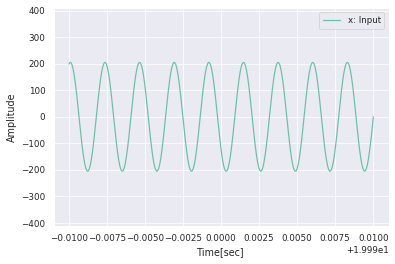

In [11]:
plt.plot(t[-tail:], x_cache[-tail:], label="x: Input")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
plt.show()

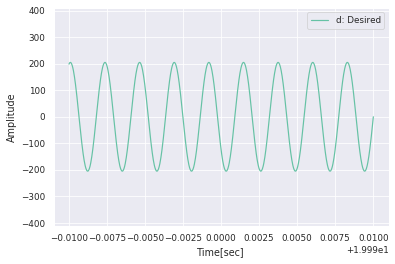

In [12]:
plt.plot(t[-tail:], d_cache[-tail:], label="d: Desired")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
plt.show()

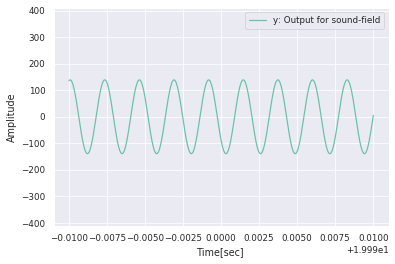

In [13]:
plt.plot(t[-tail:], y_cache[-tail:], label="y: Output for sound-field")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
plt.show()

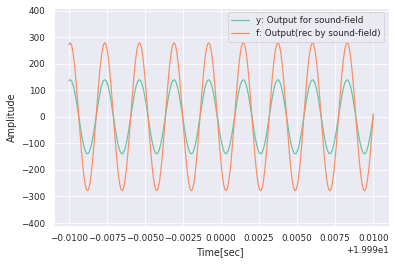

In [14]:
plt.plot(t[-tail:], y_cache[-tail:], label="y: Output for sound-field")
plt.plot(t[-tail:], f_cache[-tail:], label="f: Output(rec by sound-field)")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
plt.show()

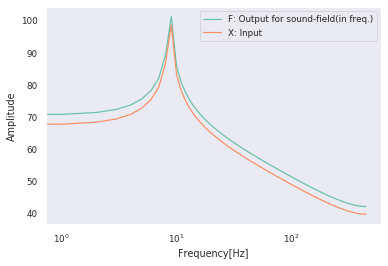

In [15]:
plt.plot(20*np.log10(rfft(f_cache[-tail:])), label="F: Output for sound-field(in freq.)")
plt.plot(20*np.log10(rfft(x_cache[-tail:])), label="X: Input")
plt.xlabel("Frequency[Hz]")
plt.ylabel("Amplitude")
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()